In [29]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn.objects as so

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

## CLUSTERING

**Ejercicio 1**

In [30]:
df_news = pd.read_csv("noticias.csv")

**Ejercicio 2**

In [31]:
df_sports = df_news[df_news["category"]=='sport']
df_sports.head()

,title,content,category
1313,Claxton hunting first major medal,British hurdler Sarah Claxton is confident she...,sport
1314,O'Sullivan could run in Worlds,Sonia O'Sullivan has indicated that she would ...,sport
1315,Greene sets sights on world title,Maurice Greene aims to wipe out the pain of lo...,sport
1316,IAAF launches fight against drugs,The IAAF - athletics' world governing body - h...,sport
1317,"Dibaba breaks 5,000m world record",Ethiopia's Tirunesh Dibaba set a new world rec...,sport


**Ejercicio 3**

In [32]:
nltk.download("stopwords")
nltk.download('punkt_tab')

stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer(language="english")

# Generamos una lista con todos los stems de palabras del texto
# (excluyendo stop words y palabras que tienen numeros o simbolos)
def tokenize_and_stem(text):
    tokens = word_tokenize(text.lower())
    stems = [stemmer.stem(token) for token in tokens if (token.isalpha() and token not in stop_words)]
    return stems

vectorizer = CountVectorizer(analyzer=tokenize_and_stem)
X = vectorizer.fit_transform(df_sports["content"])
df_sports_stems = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cristiann/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/cristiann/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


**Ejercicio 4 y 5**

In [33]:
# Calculamos componentes principales con PCA de sklearn

n=len(df_sports_stems)

pca = PCA(n_components=n)
Z = pd.DataFrame(pca.fit_transform(df_sports_stems))
autovalores = pca.explained_variance_

In [34]:
Z.columns = ["Z" + str(i) for i in range(1, len(Z.columns) + 1)] # Renombramos las columnas

Text(0.5, 1.0, 'Proyección en 2 Componentes principales con el Método bag-of-words')

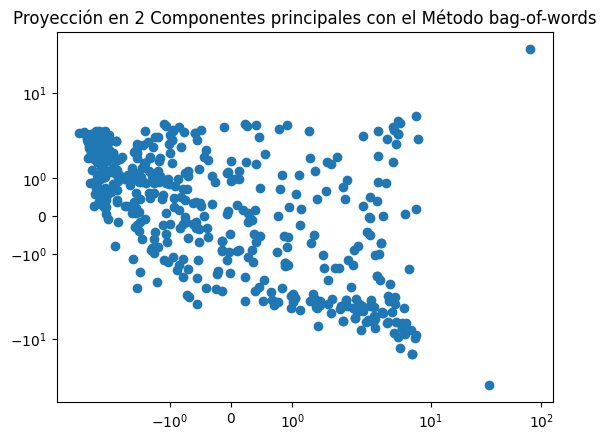

In [35]:
# Grafico en 2 PCA

plt.scatter(Z.Z1, Z.Z2)
plt.xscale('symlog') # log pero sin eliminar valores <= 0
plt.yscale('symlog')
plt.title('Proyección en 2 Componentes principales con el Método bag-of-words')

Al graficar las noticias deportivas usando palabras como si fueran números (cuántas veces aparece cada palabra), sin considerar ninguna importancia o "peso" de las mismas, vemos que casi todas las noticias terminan representadas como puntos muy juntos en un mismo cluster en una escala que no varia demasiado. Esto sugiere que son parecidas entre sí en su vocabulario, pero tenemos que pensar que muchas noticias repiten palabras iguales en todos los contextos (hoy, dia, respuesta, joven, dijo, etc.). Sin embargo, hay 2 noticias que se alejan mucho del resto y obligan a ver el grafico en escala logaritmica (outliers): esto puede deberse a que usan palabras raras o son muy distintas en longitud (muy cortas/muy largas). Esto significa que 2 autovalores no nos alcanzaron para diferenciar categorias. 

In [36]:
# Varianza explicada por los últimos n autovalores
nComps = 2
print(autovalores[:nComps].sum() / sum(autovalores))

0.09975786971534387


Los primeros 2 autovalores solo explican el 10% de la varianza, lo que hace natural que no podamos diferenciar grupos en la proyección grafica

**Ejercicio 6**

In [37]:
# Text vectorization using TF -IDF
vectorizer_tfidf = TfidfVectorizer(analyzer=tokenize_and_stem, smooth_idf=False)
X = vectorizer_tfidf.fit_transform(df_sports["content"])
df_sports_tfidf = pd.DataFrame(X.toarray (), columns=vectorizer_tfidf.get_feature_names_out ())

df_sports_tfidf.head()

,aaa,aac,aaron,abandon,abat,abbott,abc,abdomen,abdomin,abeb,...,zimbabw,zinc,zinedin,zoe,zola,zone,zornotza,zuluaga,zurich,zvonareva
0,0.090095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Opcional 1:**

In [38]:
stem = "abandon"

count_vect = CountVectorizer(analyzer=tokenize_and_stem)
X_counts = count_vect.fit_transform(df_sports["content"])
df_counts = pd.DataFrame(X_counts.toarray(), columns=count_vect.get_feature_names_out())

# Frecuencia de "abandon" en la noticia 246
frecuencia_abandon = df_counts.loc[246, stem] if stem in df_counts.columns else 0

# En cuántas noticias aparece "abandon"
docs_con_abandon = (df_counts[stem] > 0).sum() if stem in df_counts else 0

total_docs = len(df_counts)
idf = np.log(total_docs / docs_con_abandon) + 1

# TF-IDF sin normalizar
tfidf_sin_normalizar = frecuencia_abandon * idf

# Vemos cuanto peso tiene cada palabra de la noticia
noticia_246 = df_counts.loc[246]
tfidf_full_vector = np.array([
    frecuencia * (np.log(total_docs / (df_counts[word] > 0).sum()) + 1)
    if (df_counts[word] > 0).sum() > 0 else 0
    for word, frecuencia in noticia_246.items()
])

# Normalizamos
norma = np.linalg.norm(tfidf_full_vector)
tfidf_final = tfidf_sin_normalizar / norma if norma != 0 else 0

print(f"TF-IDF manual = {tfidf_final:.6f}")

TF-IDF manual = 0.204614


Comparamos con TFID vectorizer:

In [39]:
tfidf_vectorizado = df_sports_tfidf.loc[246, stem]
print(f"TF-IDF desde TfidfVectorizer = {tfidf_vectorizado:.6f}")

TF-IDF desde TfidfVectorizer = 0.204614


**Ejercicio 7**

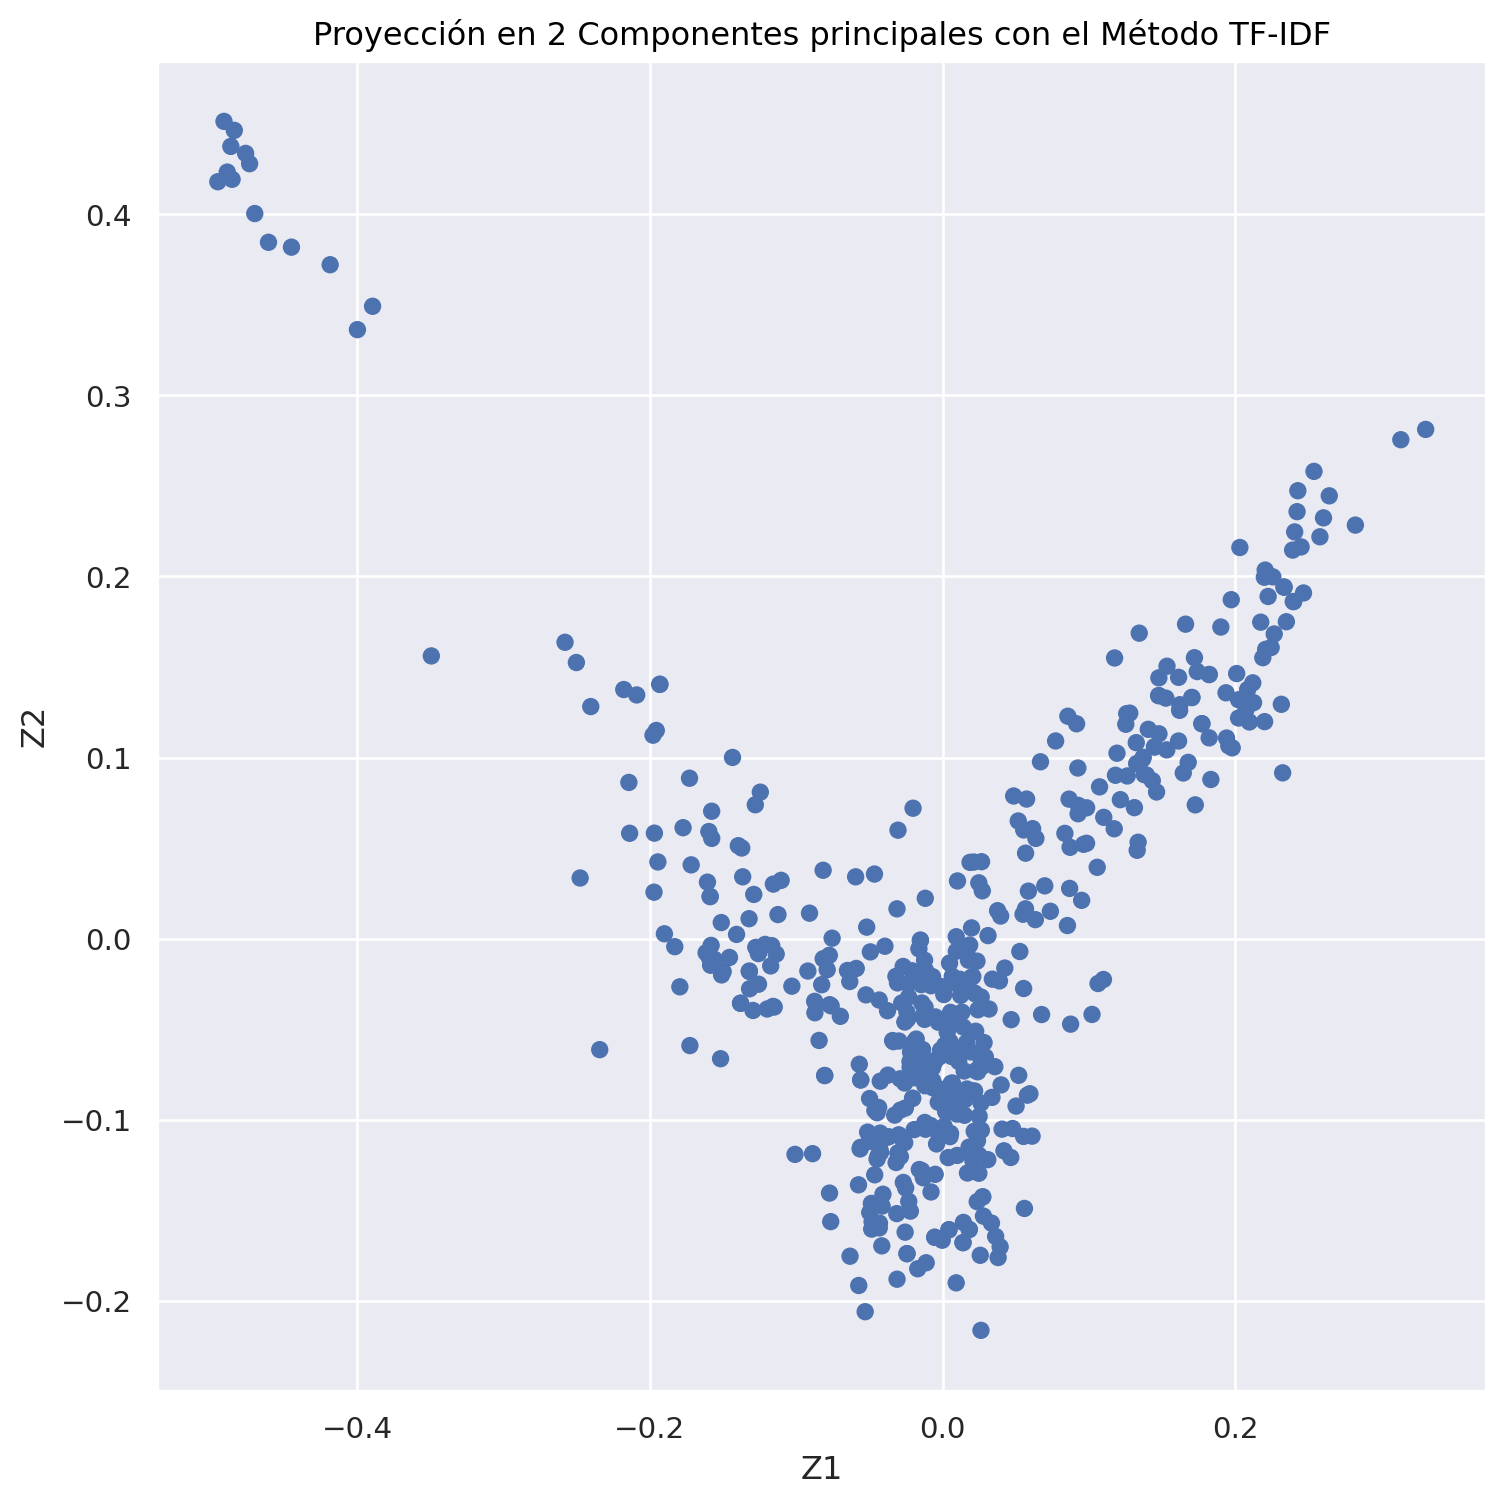

In [40]:
n=2

pca = PCA(n_components=n)
Z = pd.DataFrame(pca.fit_transform(df_sports_tfidf))
Z.columns = ["Z" + str(i) for i in range(1,n+1)]  # Renombramos las columnas

(
    so.Plot(Z, x="Z1", y="Z2")
    .add(so.Dot())
    .add(so.Text(valign="bottom"))
    .label(title="Proyección en 2 Componentes principales con el Método TF-IDF")
    .layout(size=(8,8))   # Conviene graficar en un cuadrado para ver correctamente las distancias 
)

Si bien no parece que los posibles clusters vayan a tener una forma esferica y isotropica, notamos que simultaneamente hay un grupo central muy denso y otros grupos perifericos poco densos, por lo que DBSCAN no podria separar los clusters. Entonces, probemos con Kmeans

**Ejercicios 8 y 9**

Primero, determinemos la cantidad de clusters con el metodo del "codo":

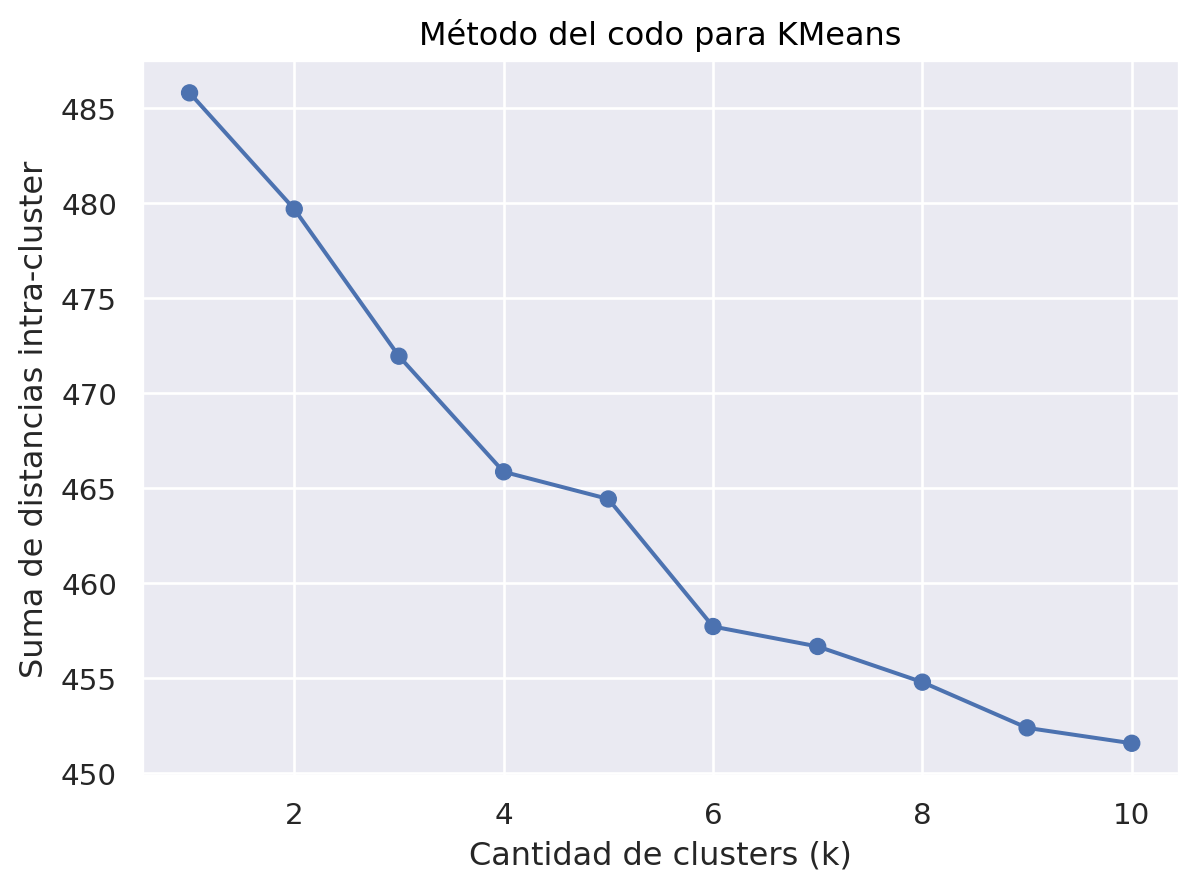

In [41]:
inertias = []
k_lista = list(range(1, 11))

for k in k_lista:
    modelo = KMeans(n_clusters=k, random_state=0)
    modelo.fit(df_sports_tfidf)
    inertias.append(modelo.inertia_)

# Graficamos
(
    so.Plot(x = k_lista, y = inertias)
    .add(so.Line())
    .add(so.Dot())
    .label(title="Método del codo para KMeans", x="Cantidad de clusters (k)", y="Suma de distancias intra-cluster")
)

Por los cambios de pendiente del Gráfico, el método nos da al 4 o al 6 como posibles candidatos a la cantidad de clusters. Probemos ambos valores para hacer una comparacion visual:

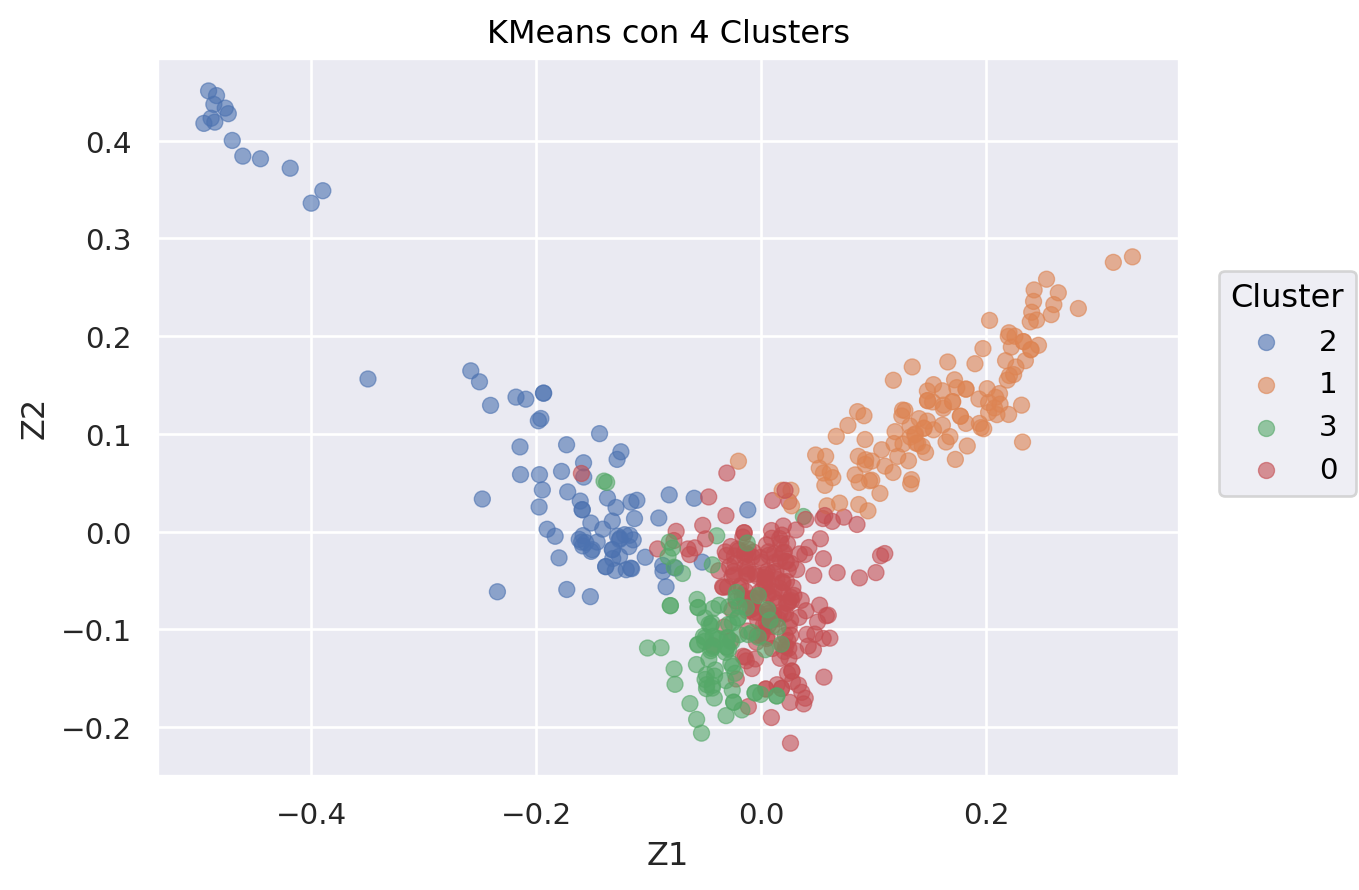

In [42]:
# KMeans con 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
etiquetas4 = kmeans.fit_predict(df_sports_tfidf)

Z = pd.DataFrame(pca.fit_transform(df_sports_tfidf), columns=["Z1", "Z2"])
Z4 = Z.copy()
Z4["cluster"] = etiquetas4.astype(str)

(
    so.Plot(Z4, x="Z1", y="Z2", color="cluster")
    .add(so.Dot(alpha=0.6))
    .label(title="KMeans con 4 Clusters", x="Z1", y="Z2", color="Cluster")
    .scale(color=so.Nominal())
    .plot()
)


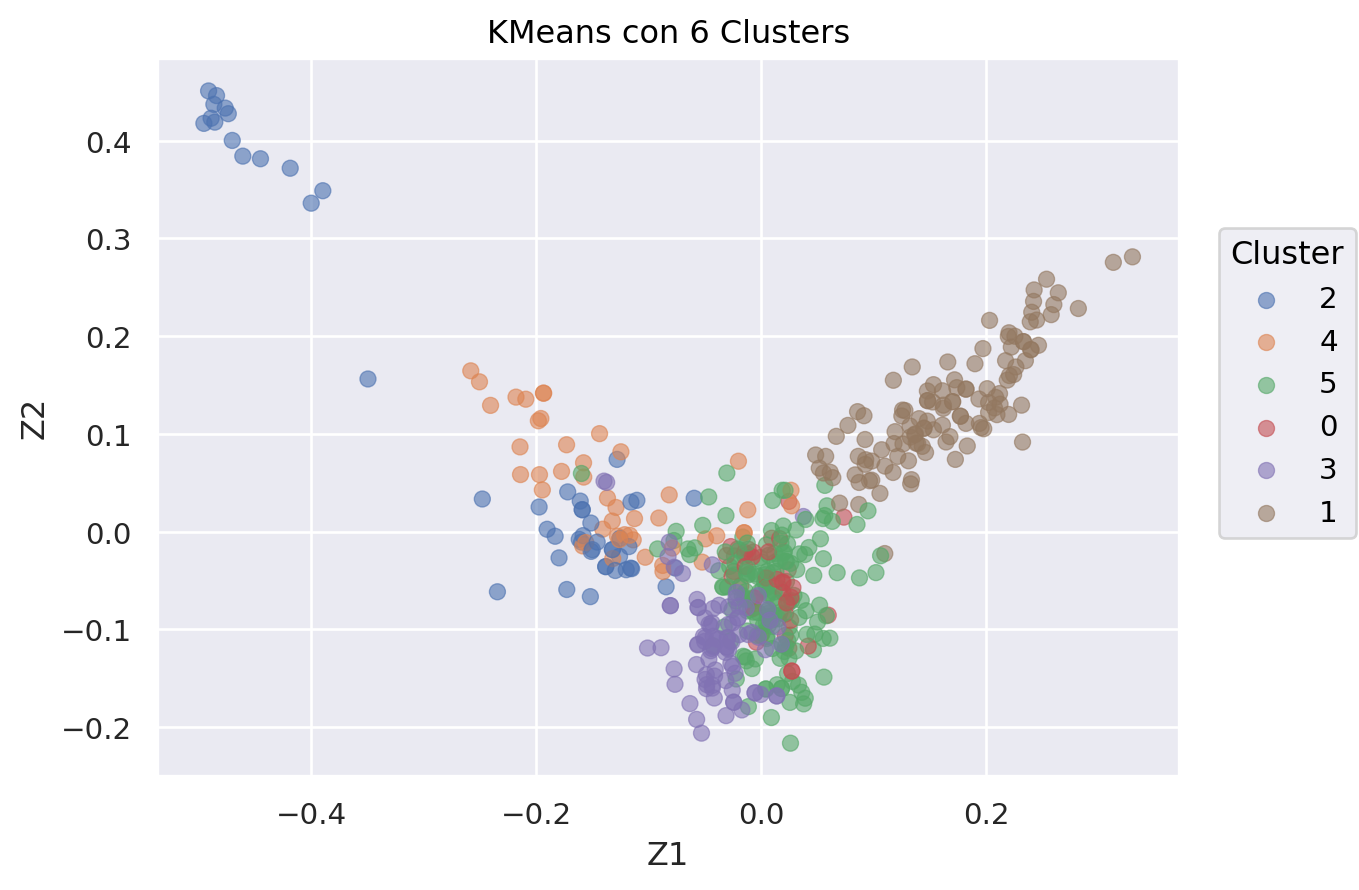

In [43]:
# KMeans con 6 clusters
kmeans = KMeans(n_clusters=6, random_state=42)
etiquetas6 = kmeans.fit_predict(df_sports_tfidf)

Z6 = Z.copy()
Z6["cluster"] = etiquetas6.astype(str)

(
    so.Plot(Z6, x="Z1", y="Z2", color="cluster")
    .add(so.Dot(alpha=0.6))
    .label(title="KMeans con 6 Clusters", x="Z1", y="Z2", color="Cluster")
    .scale(color=so.Nominal())
    .plot()
)

Comparandolo con el de 4 Clusters, lo que hace la division en 6 es separar el Cluster de la rama que va hacia Z1 negativo y también separar unos pocos elementos del que esta alrededor del 0,0. Al menos viendolo desde el grafico de la proyección en las 2 Componentes Principales, no parece que ninguna de estas separaciones vaya a ser significativamente distinta a su Cluster original, asi que nos quedamos con el de 4.

Exceptuando unos pocos casos aislados en dicha rama en Z1 negativo, los elementos en la separacion en 4 Clusters quedan cerca entre si y son casi perfectamente disjuntos en la proyección de 2 Componentes Principales

**Ejercicio 10**
Vamos a acercar un poco el grafico a cada Cluster para poder leer mejor los indices

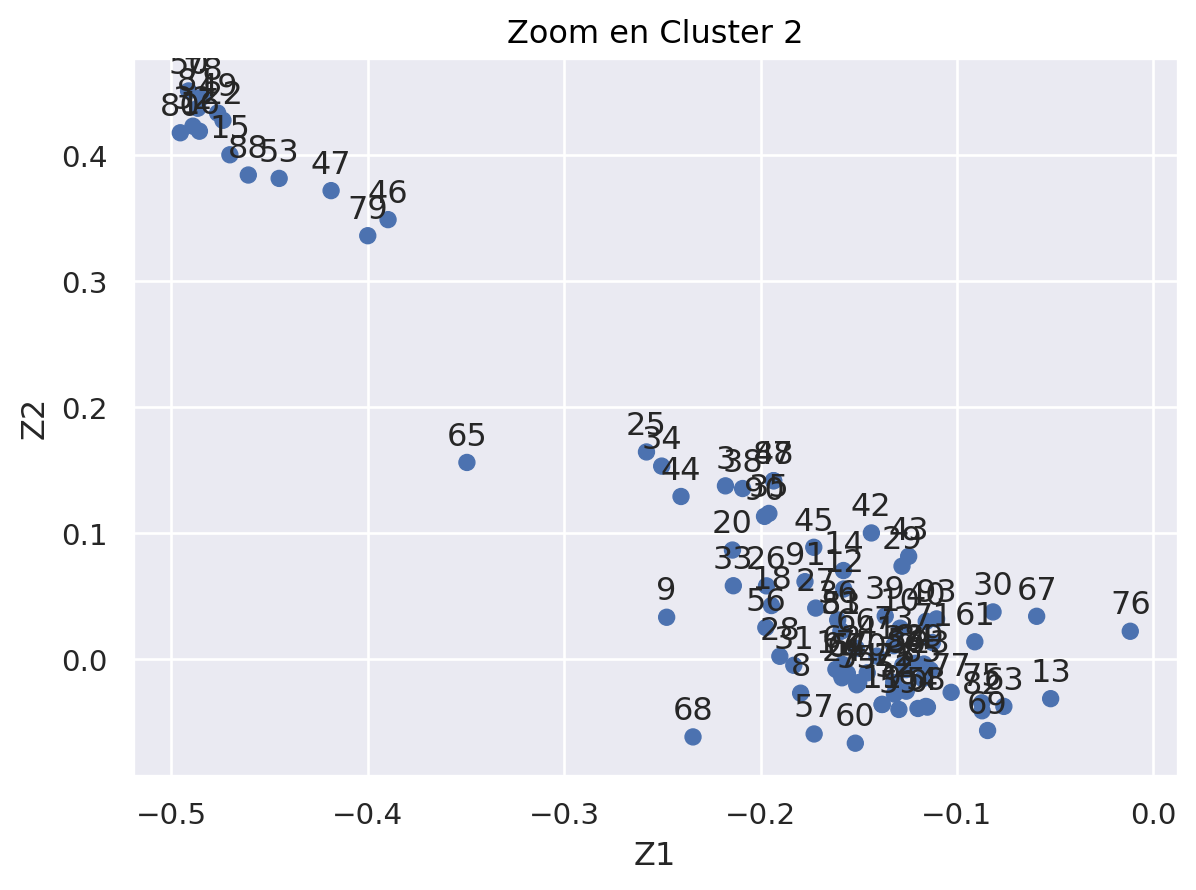

In [44]:
# Cluster 2
# cambir ZCluster2 por zcluster2

ZCluster2 = Z[(etiquetas4==2)]
(
so.Plot(ZCluster2, x="Z1", y="Z2", text=ZCluster2.index)
.add(so.Dot())
.add(so.Text(valign="bottom"))
.label(title="Zoom en Cluster 2")
)

In [45]:
# Vemos el contenido de algunas

display(df_sports.iloc[9:10])
display(df_sports.iloc[25:26])
print("Verificamos que esten en el mismo Cluster:")
print(etiquetas4[9]==etiquetas4[25])
print("¿Tambien quedaban juntas en la division por 6 Clusters?:")
print(etiquetas6[9]==etiquetas6[25])

print("\n Sigamos viendo Noticias del Cluster:")
display(df_sports.iloc[42:43])
display(df_sports.iloc[46:48])
display(df_sports.iloc[65:66])
display(df_sports.iloc[68]["content"])
display(df_sports.iloc[76]["content"])
display(df_sports.iloc[88:89])


,title,content,category
1322,Collins to compete in Birmingham,World and Commonwealth 100m champion Kim Colli...,sport


,title,content,category
1338,Collins appeals against drugs ban,Sprinter Michelle Collins has lodged an appeal...,sport


Verificamos que esten en el mismo Cluster:
True
¿Tambien quedaban juntas en la division por 6 Clusters?:
False

 Sigamos viendo Noticias del Cluster:


,title,content,category
1355,Collins named UK Athletics chief,UK Athletics has ended its search for a new pe...,sport


,title,content,category
1359,Kenteris denies faking road crash,Greek sprinter Kostas Kenteris has denied clai...,sport
1360,Greek pair set for hearing,Kostas Kenteris and Katerina Thanou will fight...,sport


,title,content,category
1378,Britain boosted by Holmes double,Athletics fans endured a year of mixed emotion...,sport


'Double Olympic champion Kelly Holmes was back to her best as she comfortably won the 1,000m at the Norwich Union Birmingham Indoor Grand Prix.\n \n The 34-year-old, running only her second competitive race of the season, shook off the rust to win in two minutes, 35.39 seconds. But she is still undecided about competing in the European Championships in Madrid from 4-6 March. "I\'ll probably be entered and make my mind up at the last minute," she said. "My training hasn\'t gone as well as expected but I\'ve got two weeks to decide. "I need to take my time and make sure I feel good about what I\'m doing. "I felt very good here but with the crowd behind you, you feel like you can do anything." American\n \n was the eventual winner of the men\'s 60m race which almost ended in farce. Three athletes were disqualified for false starting, including Britain\'s Mark Lewis-Francis, who was the first man guilty of coming out of his blocks too quickly. World 100m champion Kim Collins clinched secon

"European cross-country champion Hayley Yelling completed a hat-trick of wins in the Reebok Cardiff Cross Challenge in Bute Park on Sunday afternoon.\n \n The part-time maths teacher beat Irish international Jolene Byrne by 40 metres in the six-kilometre race. Another Great Britain international, Louise Damen, finished third as part of the contingent representing England. Peter Riley, who secured bronze for the GB men's team at last month's European Championships, won the men's 9km race. Riley, representing England, moved away over the last two kilometres to win by 25 metres from Ireland's Gary Murray. Glynn Tromans - the reigning UK Inter-Countries and England Cross-Country champion - came in third place as he continues his comeback from a five-month injury lay-off.\n"

,title,content,category
1401,Thanou desperate to make return,Greek sprinter Katerina Thanou says she is eag...,sport


Son todas noticias de atletismo. También confirmamos que quedarse con 4 Clusters fue la decision correcta, con 6 Clusters tendriamos 2 separados pero con una misma tematica

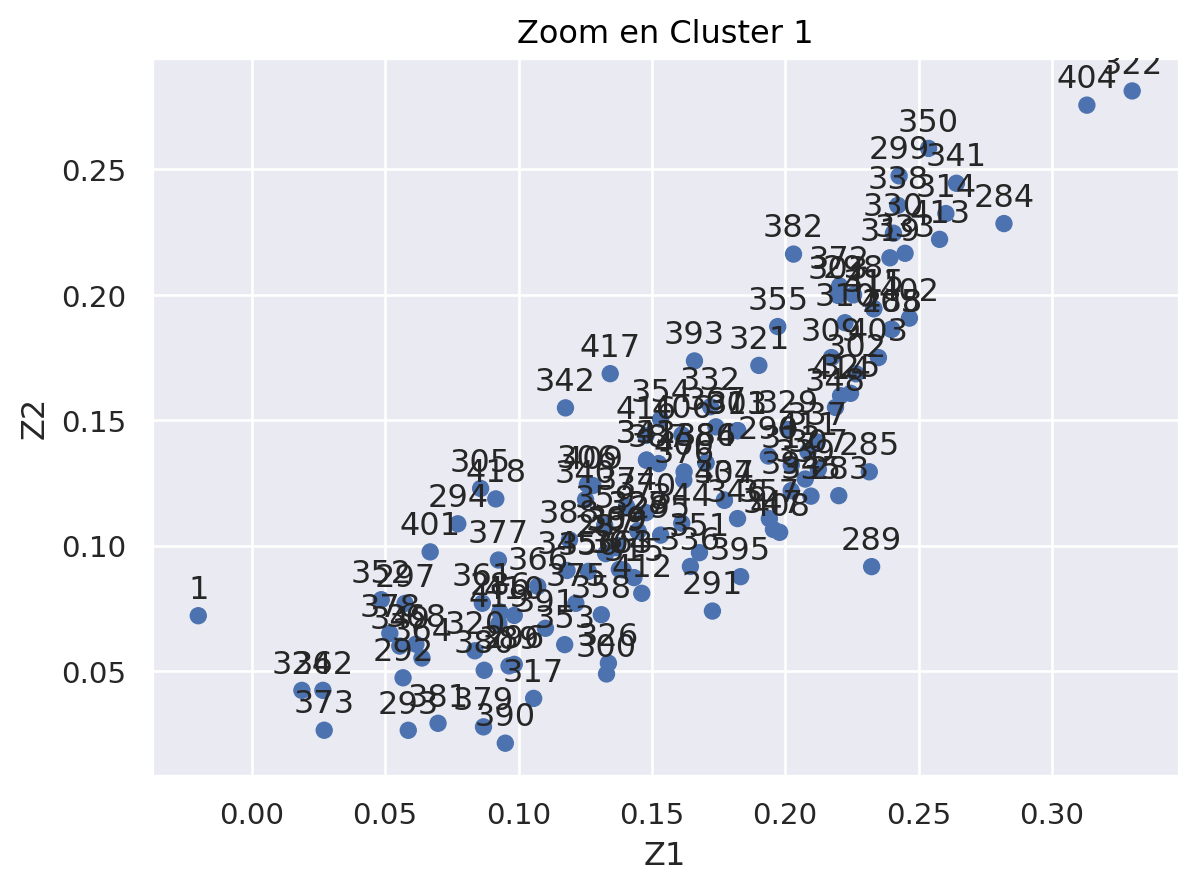

In [46]:
# Cluster 1

ZCluster1 = Z[(etiquetas4==1)]
(
so.Plot(ZCluster1, x="Z1", y="Z2", text=ZCluster1.index)
.add(so.Dot())
.add(so.Text(valign="bottom"))
.label(title="Zoom en Cluster 1")
)


In [47]:
display(df_sports.iloc[1]["content"])
display(df_sports.iloc[283:286])
display(df_sports.iloc[284]["content"])
display(df_sports.iloc[291:293])
display(df_sports.iloc[309:311])
display(df_sports.iloc[314:315])
display(df_sports.iloc[322:323])
display(df_sports.iloc[404:405])

"Sonia O'Sullivan has indicated that she would like to participate in next month's World Cross Country Championships in St Etienne.\n \n Athletics Ireland have hinted that the 35-year-old Cobh runner may be included in the official line-up for the event in France on 19-20 March. Provincial teams were selected after last Saturday's Nationals in Santry and will be officially announced this week. O'Sullivan is at present preparing for the London marathon on 17 April. The participation of O'Sullivan, currentily training at her base in Australia, would boost the Ireland team who won the bronze three years agio. The first three at Santry last Saturday, Jolene Byrne, Maria McCambridge and Fionnualla Britton, are automatic selections and will most likely form part of the long-course team. O'Sullivan will also take part in the Bupa Great Ireland Run on 9 April in Dublin.\n"

,title,content,category
1596,Hodgson shoulders England blame,Fly-half Charlie Hodgson admitted his wayward ...,sport
1597,Vickery out of Six Nations,England tight-head prop Phil Vickery has been ...,sport
1598,Yachvili savours France comeback,France scrum-half Dimitri Yachvili praised his...,sport


'England tight-head prop Phil Vickery has been ruled out of the rest of the 2005 RBS Six Nations after breaking a bone in his right forearm.\n \n Vickery was injured as his club side, Gloucester, beat Bath 17-16 in the West country derby on Saturday. He could be joined on the sidelines by Bath centre Olly Barkley, who sat out the derby due to a leg injury. Barkley will have a scan on Sunday and might miss England\'s trip to Six Nations leaders Ireland next weekend. The news is just the latest blow for coach Andy Robinson, who has seen his side lose their opening two matches in the 2005 Six Nations. Robinson is already without World Cup winners Jonny Wilkinson, Will Greenwood, Mike Tindall, Richard Hill and Trevor Woodman through injury. Vickery has broken the radius, a large bone in his forearm. He only returned to the England side last weekend after a long-term back injury, which was followed by a fractured eye socket. And the Gloucester prop was only recalled after Leicester tight-he

,title,content,category
1604,Wales coach elated with win,Mike Ruddock paid tribute to his Wales side af...,sport
1605,Newcastle 27-27 Gloucester,Newcastle centre Mathew Tait answered his crit...,sport


,title,content,category
1622,Wales make two changes for France,Wales coach Mike Ruddock has made two changes ...,sport
1623,Ireland surge past Scots,Ireland maintained their Six Nations Grand Sla...,sport


,title,content,category
1627,Barkley fit for match in Ireland,England centre Olly Barkley has been passed fi...,sport


,title,content,category
1635,Preview: Ireland v England (Sun),"Lansdowne Road, Dublin\n \n Sunday, 27 Februar...",sport


,title,content,category
1717,Ireland 19-13 England,Ireland consigned England to their third strai...,sport


Las noticias cuentan sobre enfrentamientos de Selecciones en la RBS Six Nations. Leyendo el contenido de la noticia numero 1, notamos que deberia estar en el anterior Cluster por escribir sobre el atletismo. Se puede haber filtrado por nombrar a paises que participan en el evento del Cluster actual. Tambien notamos que las palabras relacionadas al atletismo hicieron que en la proyeccion, el punto 1 se encuentre en una "zona de frontera" entre la rama izquierda y derecha

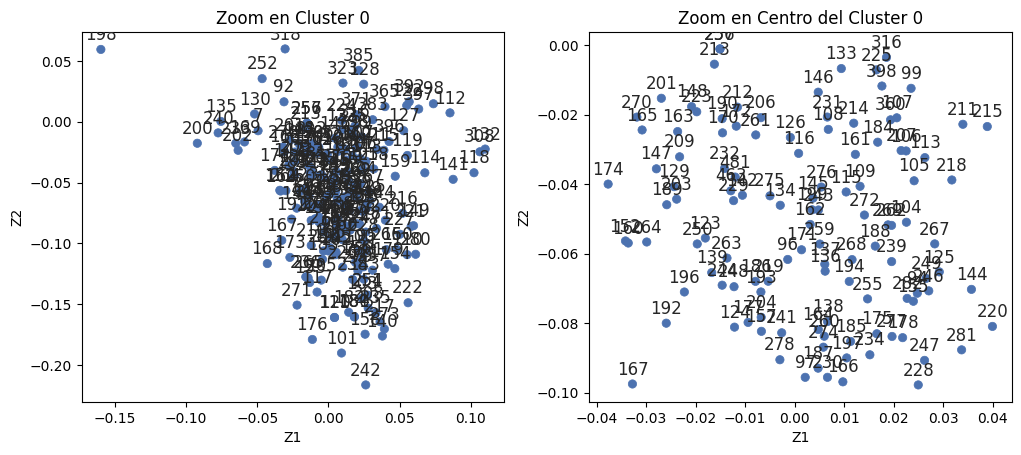

In [48]:
# Cluster 0

ZCluster0 = Z[(etiquetas4==0)]

ZCluster0Centro = ZCluster0[
    (ZCluster0["Z2"] < 0) & (ZCluster0["Z2"] > -0.1) & 
    (ZCluster0["Z1"] > -0.04) & (ZCluster0["Z1"] < 0.04)
]


fig, ax =plt.subplots(1,2)  # Utilizamos este código para crear una grilla de dos gráficos.
fig.set_figwidth(12)



(
    so.Plot(ZCluster0, x="Z1", y="Z2", text=ZCluster0.index)
    .add(so.Dot())
    .add(so.Text(valign="bottom"))
    .label(title="Zoom en Cluster 0")
                                .on(ax[0]).plot()
)


(
    so.Plot(ZCluster0Centro, x="Z1", y="Z2", text=ZCluster0Centro.index)
    .add(so.Dot())
    .add(so.Text(valign="bottom"))
    .label(title="Zoom en Centro del Cluster 0")
                                .on(ax[1]).plot()
)

plt.show()

In [49]:
display(df_sports.iloc[141]["content"])
display(df_sports.iloc[168:169])
display(df_sports.iloc[198]["content"])
display(df_sports.iloc[318:319])
display(df_sports.iloc[385]["content"])

print("Estas se ven en el Zoom")
display(df_sports.iloc[96:98])
display(df_sports.iloc[192:193])
display(df_sports.iloc[222:223])
display(df_sports.iloc[241:242])
display(df_sports.iloc[398]["content"])
display(df_sports.iloc[481:482])

'England forward Michael Owen has told the BBC he is happy in Spain and has no plans to quit Real Madrid to return to the Premiership in the near future.\n \n But the 25-year-old, who has spent much of his time coming off the bench in La Liga, did not rule out a return to the Premiership at some stage. "I\'m pleased with the start I\'ve made here," he told BBC Radio Five Live. "England is my country. It\'s definitely part of me but who knows whether, if or when I\'ll be playing there again." Owen, who moved to the Bernabeu from Liverpool last summer, has grabbed 11 goals for Real but has been unable to replace Raul or Ronaldo in the starting line-up. However, he said he was delighted with the way his time in Spain was going and dismissed criticism of his decision to join Real. "When I first came there was a lot of scepticism back in England, any maybe some out here," he said. "People were saying \'fourth-choice striker, what are you going there for? You\'ll be sat on the bench all the 

,title,content,category
1481,FA decides not to punish Mourinho,The Football Association will take no action a...,sport


'Chelsea have sacked Adrian Mutu after he failed a drugs test.\n \n The 25-year-old tested positive for a banned substance - which he later denied was cocaine - in October. Chelsea have decided to write off a possible transfer fee for Mutu, a £15.8m signing from Parma last season, who may face a two-year suspension. A statement from Chelsea explaining the decision read:"We want to make clear that Chelsea has a zero tolerance policy towards drugs." Mutu scored six goals in his first five games after arriving at Stamford Bridge but his form went into decline and he was frozen out by coach Jose Mourinho. Chelsea\'s statement added: "This applies to both performance-enhancing drugs or so-called \'recreational\' drugs. They have no place at our club or in sport. "In coming to a decision on this case, Chelsea believed the club\'s social responsibility to its fans, players, employees and other stakeholders in football regarding drugs was more important than the major financial considerations 

,title,content,category
1631,Pountney handed ban and fine,Northampton coach Budge Pountney has been fine...,sport


'Former government communications chief Alastair Campbell will act as a media consultant to Sir Clive Woodward\'s 2005 Lions on their tour to New Zealand.\n \n Campbell, who left Downing Street earlier this year, will advise on media strategy before and during the tour. "I hope I can contribute to the planning and preparation, and to ensuring the media and public get the most out of the tour itself," he said. "I am also looking forward to going out for the later stages of the tour." Woodward\'s decision to call in Prime Minister Tony Blair\'s former spin doctor springs from the deterioration in media relations on the last Lions tour of Australia in 2001, when New Zealander Graham Henry was the head coach. The furore surrounding the newspaper diaries of Matt Dawson and Austin Healey was compounded by other disillusioned players venting their frustration through the media. "The Lions is a massive media event," said Woodward, who will be the head coach. "There will be a huge level of inte

Estas se ven en el Zoom


,title,content,category
1409,Moyes U-turn on Beattie dismissal,Everton manager David Moyes will discipline st...,sport
1410,Ronaldo considering new contract,Manchester United winger Cristiano Ronaldo sai...,sport


,title,content,category
1505,Real in talks over Gravesen move,Real Madrid are closing in on a Â£2m deal for ...,sport


,title,content,category
1535,Benitez delight after crucial win,Liverpool manager Rafael Benitez admitted vict...,sport


,title,content,category
1554,Wenger rules out new keeper,Arsenal boss Arsene Wenger says he has no plan...,sport


'Wigan chairman Maurice Lindsay says he does not expect a quick solution to the on-going saga of captain Andy Farrell\'s possible switch to rugby union.\n \n Leicester and Saracens are leading the chase for the player, but Lindsay told the BBC it was not yet a done deal. "As well as the Rugby Football Union, the league, the individual club and the England coaching team have a say, so it\'s not a quick decision," he said. "He\'s given us 12 years service so if he wants to go, we\'d support him." The prospect of Farrell switching codes has been the main talking point of the Super League season so far. "It came as a bolt out of the blue to us," admitted Lindsay. "But he\'s a very loyal friend to the club, so there\'s no question that he\'s deserting us. He just fancies a challenge."\n \n Although the move would be a lucrative one for both Farrell and Wigan, Lindsay said money was not a motivating factor for the club. "The money side of things hasn\'t been concluded, but it\'s not the poin

,title,content,category
1794,Roddick in talks over new coach,Andy Roddick is reportedly close to confirming...,sport


Notamos que en su mayoria son de Futbol, pero también quedaron algunas (por ejemplo, las ultimas 2 que vimos) fuera de tema. La noticia numero 198 puede haber quedado lejos del resto en la Proyeccion por tener palabras relacionadas al escandalo de drogas de las primeras noticias del primer Cluster. De todas maneras, pudo ser correctamente identificada en el Cluster de Futbol

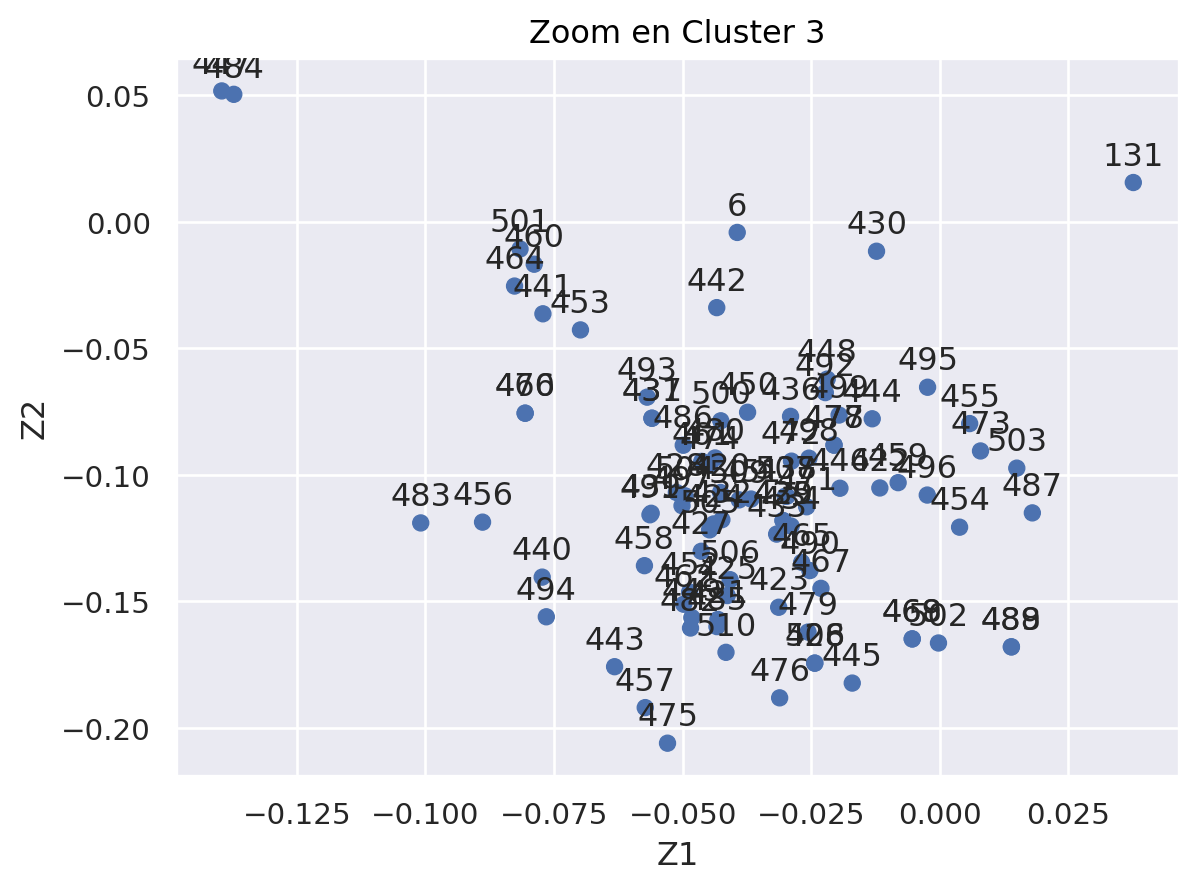

In [50]:
# Cluster 3

ZCluster3 = Z[(etiquetas4==3)]
(
so.Plot(ZCluster3, x="Z1", y="Z2", text=ZCluster3.index)
.add(so.Dot())
.add(so.Text(valign="bottom"))
.label(title="Zoom en Cluster 3")
)

In [51]:
display(df_sports.iloc[6]["content"])
display(df_sports.iloc[131]["content"])
display(df_sports.iloc[440:441])
display(df_sports.iloc[456]["content"])
display(df_sports.iloc[475:477])
display(df_sports.iloc[493:495])

print("Estas se ven en la esquina superior izquierda")
display(df_sports.iloc[447:448])
display(df_sports.iloc[484:485])

'Sonia O\'Sullivan will seek to regain her title at the Bupa Great Ireland Run on 9 April in Dublin.\n \n The 35-year-old was beaten into fourth at last year\'s event, having won it a year earlier. "I understand she\'s had a solid winter\'s training down in Australia after recovering from a minor injury," said race director Matthew Turnbull. Mark Carroll, Irish record holder at 3km, 5km and 10km, will make his debut in the mass participation 10km race. Carroll has stepped up his form in recent weeks and in late January scored an impressive 3,000m victory over leading American Alan Webb in Boston. Carroll will be facing stiff competition from Australian Craig Mottram, winner in Dublin for the last two years.\n'

'The Republic of Ireland have arranged friendlies against China and Italy which will take place at Lansdowne Road in March and August.\n \n Brian Kerr\'s side will face the 54th ranked Chinese on 29 March - just three days after the World Cup qualifier against Israel in Tel Aviv. Italy will visit on 17 August in what will be a warm-up game ahead of the autumn World Cup qualifiers. In their last meeting, the Irish beat Italy in the 1994 World Cup Finals. However, that is the Republic\'s only victory in eight attempts against the Italians who have won all the other seven games. The 29 March game will be the second time the Republic have played China - the previous encounter back in June 1984 with the Irish winning 1-0 in Sapporo, Japan. Brian Kerr said: "China have made great progress over the last few years and will provide difficult opposition. "We all witnessed the performances of the Asian teams in the last World Cup, and China play a similar type of football. "As for Italy, they mak

,title,content,category
1753,Serena becomes world number two,Serena Williams has moved up five places to se...,sport


"Mark Philippoussis withdrew from the Sydney International tennis tournament as expected on Sunday after suffering a groin injury during the Hopman Cup.\n \n His participation in the Australian Open, which begins on 17 January in Melbourne, also remains in doubt. Defending women's champion Justine Henin-Hardenne is also out of the Sydney event because of a knee injury. In the only main draw men's or women's singles match on Sunday, Nathalie Dechy beat American Lisa Raymond 7-5 6-3. Number one men's seed Lleyton Hewitt begins his quest for a fourth Sydney title on Tuesday when he plays Karol Beck. Lindsay Davenport, top seed in the women's draw, has been handed a first-round bye and plays France's Dechy in the second round on Tuesday.\n"

,title,content,category
1788,Henman to face Saulnier test,British number one Tim Henman will face France...,sport
1789,Moya suffers shock loss,Fifth seed Carlos Moya was the first big name ...,sport


,title,content,category
1806,Roche 'turns down Federer offer',Australian tennis coach Tony Roche has turned ...,sport
1807,Federer joins all-time greats,The last year has seen one player dominate men...,sport


Estas se ven en la esquina superior izquierda


,title,content,category
1760,Kuznetsova 'failed a drugs test',US Open champion Svetlana Kuznetsova has teste...,sport


,title,content,category
1797,Koubek suspended after drugs test,Stefan Koubek says he has been banned for thre...,sport


Son noticias de Tenis (exceptuando el primer par que vimos). Nuevamente, las ultimas 2 noticias pueden haber quedado lejos del resto en la Proyeccion por tener palabras relacionadas al escandalo de drogas, pero fueron correctamente clasificadas en el Cluster

Ahora como confirmación veamos las palabras mas importantes por cluster:

In [24]:
df_clusters = df_sports.copy()
df_clusters["CLUSTER"] = etiquetas4

k_real = len(np.unique(etiquetas4))
centroids = kmeans.cluster_centers_
feature_names = vectorizer.get_feature_names_out()

for i in range(k_real):
    top_indices = np.argsort(centroids[i])[-10:][::-1]
    palabras_importantes = [feature_names[j] for j in top_indices]
    print(f"\nCluster {i} - Palabras principales: {', '.join(palabras_importantes)}")


Cluster 0 - Palabras principales: v, unit, southampton, club, manag, tottenham, redknapp, home, said, forest

Cluster 1 - Palabras principales: england, wale, ireland, rugbi, nation, franc, robinson, six, game, side

Cluster 2 - Palabras principales: olymp, indoor, kenteri, athlet, athen, thanou, holm, greek, iaaf, european

Cluster 3 - Palabras principales: open, seed, australian, play, set, roddick, match, said, beat, win


Recordemos que habiamos puesto al 0 como Futbol, al 1 como RBS (rugby), al 2 como Atletismo y al 3 como Tenis. Todas las clasificaciones quedaron coherentes con el analisis de palabras mas comunes

## CLASIFICACION

**Ejercicio 11:**

In [25]:
X = vectorizer_tfidf.fit_transform(df_news["content"])
df_news_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer_tfidf.get_feature_names_out())
df_news_tfidf.shape

(2225, 18450)

**Ejercicio 12:**

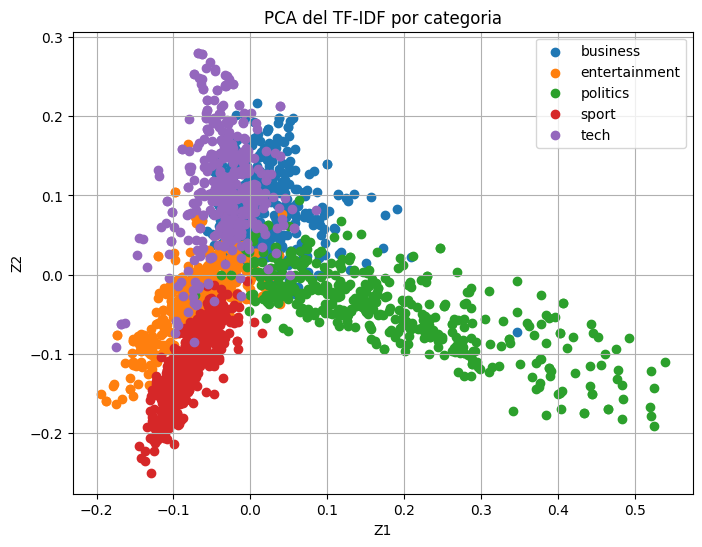

In [26]:
pca = PCA(n_components=2)
Z = pca.fit_transform(df_news_tfidf)
df_Z = pd.DataFrame(Z, columns=["Z1", "Z2"])
df_Z["category"] = df_news["category"]

plt.figure(figsize=(8,6))
for categoria in df_Z["category"].unique():
    df_cat = df_Z[df_Z["category"] == categoria]
    plt.scatter(df_cat["Z1"], df_cat["Z2"], label=categoria)
plt.xlabel("Z1")
plt.ylabel("Z2")
plt.title("PCA del TF-IDF por categoria")
plt.legend()
plt.grid(True)
plt.show()

Se observa que algunas categorías como politics y sport tienden a agruparse de forma clara, mientras que otras como business, tech y entertainment presentan una mayor superposición.

Esto sugiere que el contenido textual distingue bien ciertas temáticas específicas, pero no todas, al menos cuando se proyectan sobre las dos primeras componentes principales.
Sin embargo, es posible que categorías como business y entertainment compartan un vocabulario general similar, lo cual dificulta su separación.

**Opcional 2:**

In [27]:
componentes = pca.components_
palabras = df_news_tfidf.columns

for i, comp in enumerate(componentes):
    print(f"\nComponente Principal {i+1}:")

    mas_pos = np.argsort(comp)[-10:][::-1]
    mas_neg = np.argsort(comp)[:10]

    palabras_pos = [palabras[j] for j in mas_pos]
    palabras_neg = [palabras[j] for j in mas_neg]

    print("Palabras con mayor peso POSITIVO:")
    print(", ".join(palabras_pos))

    print("Palabras con mayor peso NEGATIVO:")
    print(", ".join(palabras_neg))




Componente Principal 1:
Palabras con mayor peso POSITIVO:
mr, labour, elect, parti, blair, tax, brown, tori, govern, minist
Palabras con mayor peso NEGATIVO:
game, film, award, best, play, player, star, music, england, win

Componente Principal 2:
Palabras con mayor peso POSITIVO:
mobil, phone, firm, market, technolog, growth, compani, use, servic, user
Palabras con mayor peso NEGATIVO:
win, england, play, best, labour, game, blair, elect, award, wale


**Ejercicio 13:**

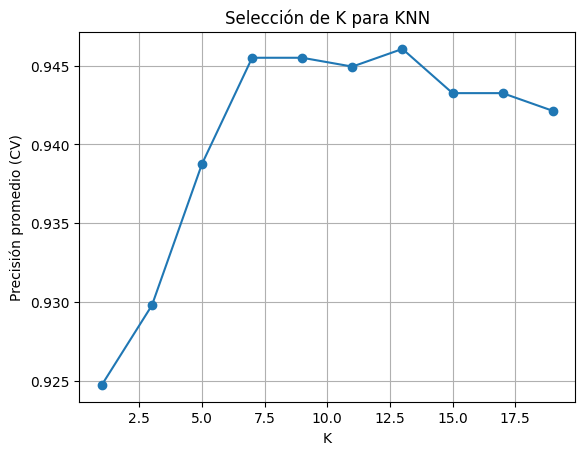

Precisión del KNN con k=13: 0.9528


In [28]:
X_train, X_test, y_train, y_test = train_test_split(df_news_tfidf, df_news["category"], test_size=0.2, random_state=0)

valores_k = list(range(1, 20, 2))
scores = [cross_val_score(KNeighborsClassifier(n_neighbors=k), X_train, y_train, cv=5).mean() for k in valores_k]

plt.plot(valores_k, scores, 'o-')
plt.xlabel("K")
plt.ylabel("Precisión promedio (CV)")
plt.title("Selección de K para KNN")
plt.grid(True)
plt.show()

mejor_k = valores_k[scores.index(max(scores))]
modelo_knn = KNeighborsClassifier(n_neighbors=mejor_k)
modelo_knn.fit(X_train, y_train)
y_pred = modelo_knn.predict(X_test)
accuracy_knn = (y_pred == y_test).mean()
print(f"Precisión del KNN con k={mejor_k}: {accuracy_knn:.4f}")

**Opcional 3:**

Componentes necesarias para explicar al menos el 10% de la varianza: 18


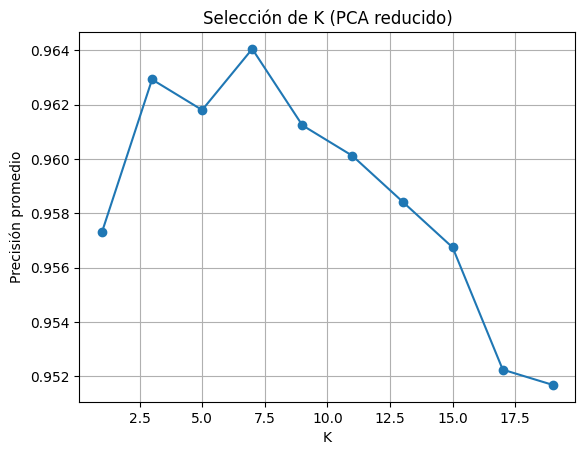

Precisión con PCA reducido (k=7): 0.9528


In [29]:
pca_total = PCA()
Z = pca_total.fit_transform(df_news_tfidf)

# Ver proporción de varianza explicada
varianza_acumulada = np.cumsum(pca_total.explained_variance_ratio_)
num_componentes = np.argmax(varianza_acumulada >= 0.10) + 1

print(f"Componentes necesarias para explicar al menos el 10% de la varianza: {num_componentes}")

# Reducimos el dataset a esas componentes
Z = pd.DataFrame(Z[:, :num_componentes])

X_train, X_test, y_train, y_test = train_test_split(Z, df_news["category"], test_size=0.2, random_state=0)

valores_k = list(range(1, 20, 2))
precisiones = [cross_val_score(KNeighborsClassifier(n_neighbors=k), X_train, y_train, cv=5).mean() for k in valores_k]

# Graficamos
plt.plot(valores_k, precisiones, 'o-')
plt.xlabel("K")
plt.ylabel("Precisión promedio")
plt.title("Selección de K (PCA reducido)")
plt.grid(True)
plt.show()

k_optimo = valores_k[np.argmax(precisiones)]
modelo_pca = KNeighborsClassifier(n_neighbors=k_optimo)
modelo_pca.fit(X_train, y_train)
precision_pca = modelo_pca.score(X_test, y_test)

print(f"Precisión con PCA reducido (k={k_optimo}): {precision_pca:.4f}")

## CLASIFICACION UTILIZANDO TITULOS DE LAS NOTICIAS

**Ejercicio 14:**

In [30]:
vectorizador = TfidfVectorizer(stop_words='english')
X_titulos = vectorizador.fit_transform(df_news["title"])

df_titulos_tfidf = pd.DataFrame(X_titulos.toarray(), columns=vectorizador.get_feature_names_out())

df_titulos_tfidf.head()

,000,000m,05,10,100,100m,102,10bn,11,110,...,york,young,youngsters,youssou,youth,yukos,zambia,zealand,zeros,zombie
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.345019,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


**Ejercicio 15:**

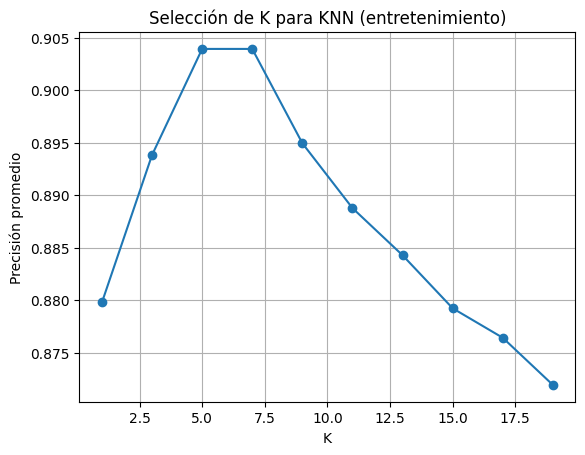

Precisión para 'entretenimiento' con KNN (k=5): 0.9213


In [31]:
y_ent = df_news["category"] == "entertainment"
X_train, X_test, y_train, y_test = train_test_split(df_titulos_tfidf, y_ent, test_size=0.2, random_state=0)

valores_k = list(range(1, 20, 2))
scores = [cross_val_score(KNeighborsClassifier(n_neighbors=k), X_train, y_train, cv=5).mean() for k in valores_k]

plt.plot(valores_k, scores, 'o-')
plt.xlabel("K")
plt.ylabel("Precisión promedio")
plt.title("Selección de K para KNN (entretenimiento)")
plt.grid(True)
plt.show()

k_ent = valores_k[scores.index(max(scores))]
modelo_ent = KNeighborsClassifier(n_neighbors=k_ent)
modelo_ent.fit(X_train, y_train)
acc_ent = modelo_ent.score(X_test, y_test)
print(f"Precisión para 'entretenimiento' con KNN (k={k_ent}): {acc_ent:.4f}")

**Ejercicio 16 y 17:**

Probemos con regresión logística:

In [32]:
modelo_log = LogisticRegression(max_iter=1000)
modelo_log.fit(X_train, y_train)

predicciones_log = modelo_log.predict(X_test)

aciertos_log = (predicciones_log == y_test).mean()
print(f"Precisión regresión logística: {aciertos_log:.4f}")

Precisión regresión logística: 0.8539


Ahora, con una red neuronal:

In [38]:
# revisar

mlp = MLPClassifier(hidden_layer_sizes=(50,), activation="logistic", max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

y_pred_nn = mlp.predict(X_test)
acc_nn = (y_pred_nn == y_test).mean()
print(f"Precisión de la red neuronal: {acc_nn:.4f}")

Precisión de la red neuronal: 0.9303


KNN: 91.91%
Regresión logística: 85.39%
Redes Neuronales: 93.03%
  
KNN no intenta entender el significado profundo de cada título. En lugar de eso, cuando ve una noticia nueva, la compara directamente con otras noticias que ya conoce. Si encuentra varios títulos parecidos que son de entretenimiento, asume que el nuevo también lo es. En este caso funciona bastante bien porque muchos títulos de noticias de entretenimiento en general son cortos y usan palabras claves parecidas como “movie”, “actor”, “show”, etc.

En cambio, la regresión logística intenta buscar una “fórmula”/“regla general” que separe los títulos de una categoría de los de otra. Esto puede ser más difícil cuando los títulos son muy variados, usan diferentes formas de decir lo mismo, o contienen palabras que no son muy específicas.

Redes neuronales aprende patrones más complejos y combina distintas palabras para entender mejor a qué categoría pertenece un título, asi que se adapta mejor cuando hay relaciones no tan evidentes entre las palabras y las categorías (por eso tiene tanta diferencia con Regresion Logistica).

En resumen, KNN se adapta mejor cuando las noticias tienen títulos cortos y directos, ya que puede simplemente buscar otras noticias similares y copiar su categoría. La regresión logística es buena también, pero al intentar aplicar una regla fija a títulos muy variados, pierde precisión. Redes neuronales puede entender relaciones más complejas y por ende fue el que mejor clasificó en este caso (teniendo en cuenta que en las noticias suelen usarse titulos con jergas, juegos de palabras o relacionados a cosas que los "fans" entienden).